# Convolutional Neural Network
From DNN to CNN:   
The DNN fully-connected network suffers from a profusion of parameters,
starting with one parameter between every input feature to every neuron
of the first internal layer.
In standard image analysis, each pixel is a feature.
Given so many input features per image, dense neural networks are impractical.
The CNN architecture uses shared weights to reduce the number of trainable parameters.

Acknowledgement:   
This notebook is a modification of my DenseNeuralNetwork notebook.
I used help from Jason Brownlee's tutorials on  
[MNIST](https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/) and the
[Functional API](https://machinelearningmastery.com/keras-functional-api-deep-learning/)

## Architecture
Layers:    
The neural network architecture is: 
Input Layer that reads features | 
Convolutional Layer(s) that have filters with trainable weights | 
Flatten Layer that converts a 3D array (num filters * width * hight) to 1D | 
Dense Layer(s) that treat convolution scores as features | 
Output Layer that generates scores for classification.

CNN + DNN?   
Note that the CNN incorporates a DNN. 
The DNN layers provide classification based on convolutional features.
(A fully-convolutional neural network, such as U-Net, has no dense layers,
and it is not designed for classification.)

Filters or Kernels:    
The CNN network consists of filters, also called kernels.
Each filter is a mini-neural-network that produces a score for an image region.
The region, called the receptive field, is usually a small square, such as 3x3 pixels.
Each filter slides around the 2D input, scoring the center pixel of that region.
If some filter gives high scores to dots, we say it recognizes dots.
Layers of filters build on each other, 
such that early filters recognize simple patterns like edges and dots,
while late filters recongnize compound patterns like cats and dogs.
One filter can recognize its pattern at any number of locations around the input.
Training a CNN involves tuning the filters to output useful scores. 

## Training and Evaluation
Training and evaluating the model works identically for CNN as for DNN.
Please see my notes on the DenseNeuralNetwork notebook.

In [1]:
import datetime
print(datetime.datetime.now())
from platform import python_version
print('Python',python_version())
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests

2022-09-06 10:43:12.699755
Python 3.10.0


In [2]:
import tensorflow as tf
from tensorflow import keras
from keras import layers
from sklearn.model_selection import StratifiedKFold

## The Dataset
MNIST:   
We'll use the MNIST dataset,
famous because it was used by Yann LeCun 
to develop the first convolutional neural network.

Color vs B & W:    
In black and white images, each pixel has 1 value representing greyscale.
In color images, each pixel has 3 values representing the RGB channels.
In MNIST, there are 70K greyscale images of 28x28 pixels. 
Each image is centered on a single, hand-written digit.
Each label is one of 0, 1, 2, ... 9.

Shuffle:  
The data are provided in random order so there is no need to shuffle.

Train and test:    
The data are in random order, so we just set aside the last 10K as the unseen data.

In [3]:
(X_seen, y_seen), (X_unseen, y_unseen) = keras.datasets.mnist.load_data()
print('Train:',X_seen.shape,y_seen.shape)
print('Test: ',X_unseen.shape,y_unseen.shape)
num_instances = X_seen.shape[0]
CHANNELS_PER_PIXEL = 1 # we have greyscale inputs
image_shape = (X_seen.shape[1],X_seen.shape[2],CHANNELS_PER_PIXEL) 
num_features = X_seen.shape[1] * X_seen.shape[2] 
num_labels = len(np.unique(y_seen))
print('Num labels:',num_labels)

Train: (60000, 28, 28) (60000,)
Test:  (10000, 28, 28) (10000,)
Num labels: 10


In [4]:
# Here are the species labels. Each y corresponds to a row of X_seen.
y_seen[:10]

array([5, 0, 4, 1, 9, 2, 1, 3, 1, 4], dtype=uint8)

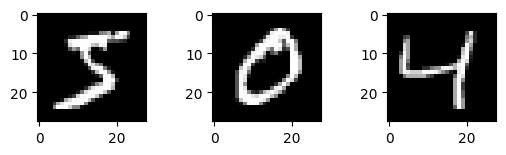

Image labels: [5 0 4]
Image data structure: <class 'numpy.ndarray'> (28, 28)
Pixel value range: 0 to 255


In [5]:
# Here is some raw data, not normalized.
for i in range(3):
    plt.subplot(330 + 1 + i)
    plt.imshow(X_seen[i], cmap=plt.get_cmap('gray'))
plt.show()
print('Image labels:',y_seen[:3])
print('Image data structure:',type(X_seen[0]),X_seen[0].shape)
print('Pixel value range:',np.amin(X_seen[0]),'to',np.amax(X_seen[0]))

### Normalization
Without normalization, pixel values range from 0 to 255.
This is a problem if low-intensity differences (like 0 vs 1)
seem huge compared to high-intensity differences (like 254 vs 255).
We simply divide every pixel by 255.
Do this to the train and test sets.

In [6]:
X_seen = X_seen/255.0
X_unseen = X_unseen/255.0
print('Normalized pixel value range:',np.amin(X_seen[0]),'to',np.amax(X_seen[0]))

Normalized pixel value range: 0.0 to 1.0


## Model Architecture
See also:    
Please see my notes on the DenseNeuralNetwork notebook.
Keras model building works identically for CNN as for DNN.

Conv2D:    
The big CNN/DNN difference is CNN's use of the Keras Conv2D layer.
Conv2D requires parameters to specify the number of filters, and the size of those filters.
Like Dense, Conv2D uses the Xavier/Glorot uniform initializer by default.

In [7]:
def make_model(name):
    KERNEL_SHAPE = (3,3)
    inputs  =  keras.Input(shape=image_shape)
    prev    =  inputs
    prev    =  layers.Conv2D(30, KERNEL_SHAPE, 
                             activation='relu'  ) (prev) 
  #  kernel_initializer='he_uniform') (prev)                          
    prev    =  layers.Flatten()                               (prev)
    prev    =  layers.Dense(10, activation="relu")            (prev)
    outputs =  layers.Dense(num_labels, activation="softmax") (prev)
    new_model = keras.Model(inputs=inputs, outputs=outputs, name=name)
    new_model.compile(
        loss=keras.losses.SparseCategoricalCrossentropy(),
        optimizer=keras.optimizers.RMSprop(),
        metrics=["accuracy"])
    return new_model

## Count the trainable parameters
Here we explain the number of trainable parameters that are shown below.
1. Conv2D(30): 30 kernels * (3 * 3 inputs + 1 bias) = 300 
1. Flatten:
The kernel never scores the pixels along the very top, bottom, left, and right.
This is because we are using valid convolution.
(The alternative, called same convolution, 
adds pixels along the top, bottom, left, and right,
and uses some rule to fill their pixel values.)
Since the input is 28 * 28, each 3 * 3 kernel visits 26 * 26 positions.
Thus, Flatten has (26 * 26) pixels * 30 kernels = 20280 outputs.
1. Dense(10): 10 neurons * (20280 inputs + 1 bias) = 202810 parameters.
1. Output(10): 10 neurons * (10 inputs + 1 bias) = 110 parameters. 

In [8]:
demo = make_model("Demo")
demo.summary()

Model: "Demo"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 30)        300       
                                                                 
 flatten (Flatten)           (None, 20280)             0         
                                                                 
 dense (Dense)               (None, 10)                202810    
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
Total params: 203,220
Trainable params: 203,220
Non-trainable params: 0
_________________________________________________________________


2022-09-06 10:43:27.797472: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Training and Validation
See also:    
Please see my notes on the DenseNeuralNetwork notebook.
Training and validation work identically for CNN as for DNN.

CNN run time:    
The CNN training is computationally demanding.
This can be alleviated by use of a GPU (which was not used here).

In [9]:
# Use seen data only. Do not peek at unseen data.
EPOCHS=2
SPLITS=3
fold=0
skf = StratifiedKFold(n_splits=SPLITS)
history_vector=[None]*SPLITS
valid_vector  =[None]*SPLITS
def tensor_slice(tensor,index):
    array = np.array(tensor)
    subset = array[index]
    tensor = tf.convert_to_tensor(subset)
    return tensor
for train, valid in skf.split(X_seen,y_seen):
    X_train = tensor_slice(X_seen,train)
    y_train = tensor_slice(y_seen,train)
    X_valid = tensor_slice(X_seen,valid)
    y_valid = tensor_slice(y_seen,valid)
    validata = (X_valid,y_valid)
    name = "MLP_"+str(fold)
    fold_model  = make_model(name)
    fold_history = fold_model.fit(X_train,y_train,
                                  epochs=EPOCHS,validation_data=validata)
    # The call to evaluate() is redundant with fit(validation_data),
    # but it provides a quick & easy way to get the final validation scores.
    fold_valid = None
    fold_valid = fold_model.evaluate(X_valid, y_valid)
    history_vector[fold]=fold_history
    valid_vector  [fold]=fold_valid
    fold += 1
    print("Fold", fold,"Valid accuracy:",fold_valid[1],"Valid loss:", fold_valid[0])

Epoch 1/2
1250/1250 [==============================] - 16s 12ms/step - loss: 0.5813 - accuracy: 0.8175 - val_loss: 0.2503 - val_accuracy: 0.9298
Epoch 2/2
625/625 [==============================] - 2s 4ms/step - loss: 0.1589 - accuracy: 0.9532
Fold 1 Valid accuracy: 0.953249990940094 Valid loss: 0.15886859595775604
Epoch 1/2
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3118 - accuracy: 0.9076 - val_loss: 0.1308 - val_accuracy: 0.9631
Epoch 2/2
625/625 [==============================] - 3s 4ms/step - loss: 0.0985 - accuracy: 0.9728
Fold 2 Valid accuracy: 0.9727500081062317 Valid loss: 0.09850933402776718
Epoch 1/2
1250/1250 [==============================] - 17s 13ms/step - loss: 0.4731 - accuracy: 0.8594 - val_loss: 0.1904 - val_accuracy: 0.9463
Epoch 2/2
625/625 [==============================] - 2s 4ms/step - loss: 0.1279 - accuracy: 0.9623
Fold 3 Valid accuracy: 0.9623000025749207 Valid loss: 0.12791144847869873


## Summarize the training and validation 
Within each round of cross valication,
after each epoch,
we measured train accuracy, train loss, validation accuracy, validation loss.
Now they can be plotted over time.

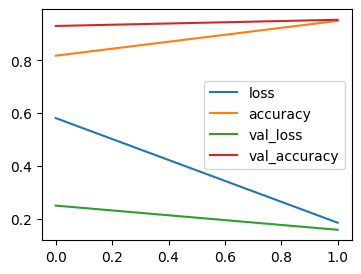

Fold 1 Final Validation acc = 0.95 loss =0.16


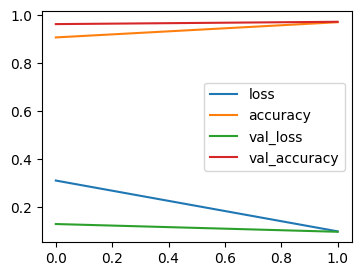

Fold 2 Final Validation acc = 0.97 loss =0.10


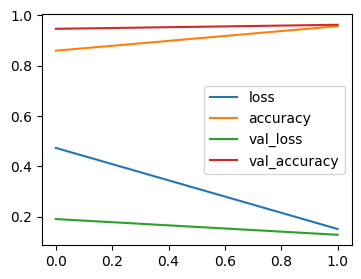

Fold 3 Final Validation acc = 0.96 loss =0.13


In [13]:
for fold in range(SPLITS):
    one_history = history_vector[fold]
    pair = valid_vector[fold]
    pd.DataFrame(one_history.history).plot(figsize=(4,3))
    plt.show()
    print('Fold %d Final Validation acc = %.2f loss =%.2f'%(fold+1,pair[1],pair[0]))

# Finally, compute test accuracy
Do this only after settling on the model hyperparameters once and for all.

Epoch 1/2
2400/2400 [==============================] - 23s 9ms/step - loss: 0.2800 - accuracy: 0.9190
Epoch 2/2
313/313 [==============================] - 1s 4ms/step - loss: 0.0927 - accuracy: 0.9727


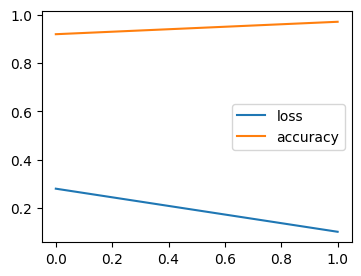

In [14]:
# Finally, we peek at the unseen data.
# Train a model on all the seen data previously used for in cross validation.
# Then test on unseen data for the first time.
final_model = None
X_train = X_seen  # don't need tf.convert_to_tensor()
y_train = y_seen
X_test  = X_unseen
y_test  = y_unseen
name = "MLP_final"
final_model   = make_model(name)
final_history = final_model.fit(X_train, y_train, batch_size=25, epochs=EPOCHS)
test_scores   = final_model.evaluate(X_test, y_test)
pd.DataFrame(final_history.history).plot(figsize=(4,3))
plt.show()

## Here is our final test accuracy:
High accuracy is not expected as we used a rather small neural network. 
Anything better than 10% is better than guessing.
So, our high accuracy is surprising.

In [15]:
print()
print('Test acc = %.2f loss = %.2f'%(test_scores[1],test_scores[0]))


Test acc = 0.97 loss = 0.09
